# Aircraft Surface Positioning Pipeline Demo

- Dataset: Tufts univerity turf field
- Pose estimations: Generated through COLMAP (Schonberger and Frahm, 2016)



NOTES:
- All 'Visualizer' steps are for visualization purposes only, can be commented out

In [1]:
from groundNAV_agent import *
from pathlib import Path

/home/daniel-choate/miniconda3/envs/py39/lib/python3.9/site-packages/dash/dash.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, parse_version


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Input files: 
- SfM solution (3)
    - Images
    - Cameras
    - 3D Cloud
- Local Images for registration (10)
- Satellite reference image (1)

In [2]:
# SfM files 
images_colm = '../sample_data/SfM_soln/images.txt'
cameras_colm = '../sample_data/SfM_soln/cameras.txt'
pts3d_colm = '../sample_data/SfM_soln/points3D_f.txt'

# Local images - folder
im_local = '../sample_data/local_imgs'

# Satellite reference image
sat_ref = '../sample_data/TurfSat.jpg'

In [3]:
# Create class 
gnav = gNAV_agent(images_colm, cameras_colm, pts3d_colm, im_local, sat_ref)

___________________________________
### Visualizer (1)
- Initial pose estimation and sparse point cloud

In [4]:
# # Visualize the sparse scene and camera poses generated through SfM 

# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name = "Pose estimations and sparse cloud: SfM COORDINATES (not absolute)")

# gnav.pose_scene_visualization(vis)

__________________________________________

## Set Reference Frame 

In [5]:
# Set reference frame - transform to ground-parallel coordinate frame 
tform_ref_frame = gnav.set_ref_frame(gnav.pts_gnd_idx)
tform_ref_frame_pts = gnav.inv_homog_transform(tform_ref_frame)
print("\nReference frame transformation\n", tform_ref_frame_pts)

# Transfer all points to new coordinate system
origin_ref, scene_pts_ref, scene_vec_ref = gnav.unit_vec_tform(gnav.scene_pts, gnav.origin_w, tform_ref_frame_pts)


Reference frame transformation
 [[-1.55069060e-03  9.81197008e-01  1.93002661e-01 -1.21025836e-01]
 [-1.42845166e-01 -1.91240997e-01  9.71093270e-01  1.86102525e+00]
 [ 9.89743833e-01 -2.60636319e-02  1.40455805e-01  7.28134156e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


____________________________________
### Visualizer (2)

- Sparse point cloud in NEW (ground-referenced) frame

In [6]:
# # Visualize the sparse scene and camera poses generated through SfM 

# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name = "Sparse cloud: ground-reference coords")

# gnav.pose_scene_visualization_ref(vis, scene_pts_ref)

__________________________________________________________

## Image Mosaic Formulation

In [7]:
# Import mosaic parameters - arbitrarily obtained, can be modified
mosaic_params = np.load('../sample_data/GP_sections/mosaic_params.npy')
# Grab specified image points from local images 
gnav.grab_image_pts_tot(mosaic_params)

____________________________________________
### Visualizer (3)

- Ground plane sections from 2D image to be used for mosaic

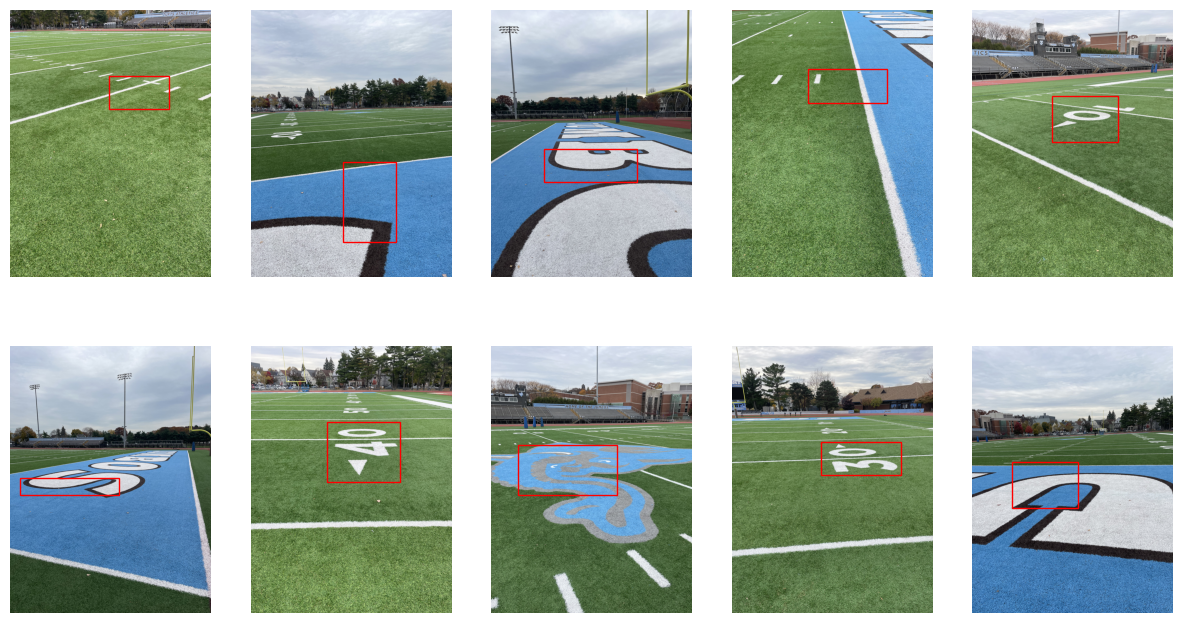

In [8]:
plt.figure(figsize=(15,8))
gnav.plot_gnd_pts()

_________________________________________________________

## Image mosaic formulation stages 
1. Create unit vectors in camera coordinates
2. Grab transformation matrix (camera to world (SfM) coords)
3. Transform to world (SfM) coords
4. Projection on ground plane
5. Transform to ground-referenced plane

In [9]:
# Generate projection of image sections 
for i in range(len(gnav.images_dict)):
    # STEP 1: Unit vectors in camera coords 
    pts_vec_c, pts_rgb_gnd = gnav.unit_vec_c(i)
    gnav.im_mosaic[i] = {'rgbc': pts_rgb_gnd}

    # STEP 2: Transformation matrix moves from camera coords to world coords
    id = gnav.im_ids[i]
    homog_w2c, homog_c2w = gnav.get_pose_id(id,i)
    # print('Homogeneous transformation from world to camera \n', homog_c2w)
    # print('\n Homogeneous transformation from camera to world \n', homog_w2c)

    # STEP 3: Transform to world coords
    origin_c, pts_loc_w, pts_vec_w = gnav.unit_vec_tform(pts_vec_c, gnav.origin_w, homog_c2w)
    # print('\n New camera frame origin = ', origin_c)
    
    # STEP 4: Get new points 
    ranges, new_pts_w = gnav.pt_range(pts_vec_w, homog_c2w, origin_c, i)
    # print('\nNew Points \n', new_pts_w)

    # STEP 5: Transfer points to reference frame
    __, new_pts_r, pts_vec_r = gnav.unit_vec_tform(new_pts_w, gnav.origin_w, tform_ref_frame_pts)

    # Convert points to grayscale 
    gray_c = gnav.conv_to_gray(gnav.im_mosaic[i]['rgbc'],i)
    # print(gray_c)

    # Put new points and grayscale colors in image mosaic
    gnav.im_mosaic[i]['pts'] = new_pts_r
    gnav.im_mosaic[i]['color_g'] = gray_c
    
    print("\nDone image ", i)


Done image  0

Done image  1

Done image  2

Done image  3

Done image  4

Done image  5

Done image  6

Done image  7

Done image  8

Done image  9


_____________________________________
### Visualizer (4)

- Image mosaic formulation

In [10]:
# Create visualization
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Image mosaic formulation")

gnav.mosaic_visualization(vis)

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 80
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 80
pci id for fd 80: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


________________________________________